# Windy Gridworld - Assignment 2
Name: Jake Ahearne
Student Number: 20039207


# Discussion Section
1. Implementation of all algorithms for the first case is worth 30 points. This includes the quality of
your code and its correctness.
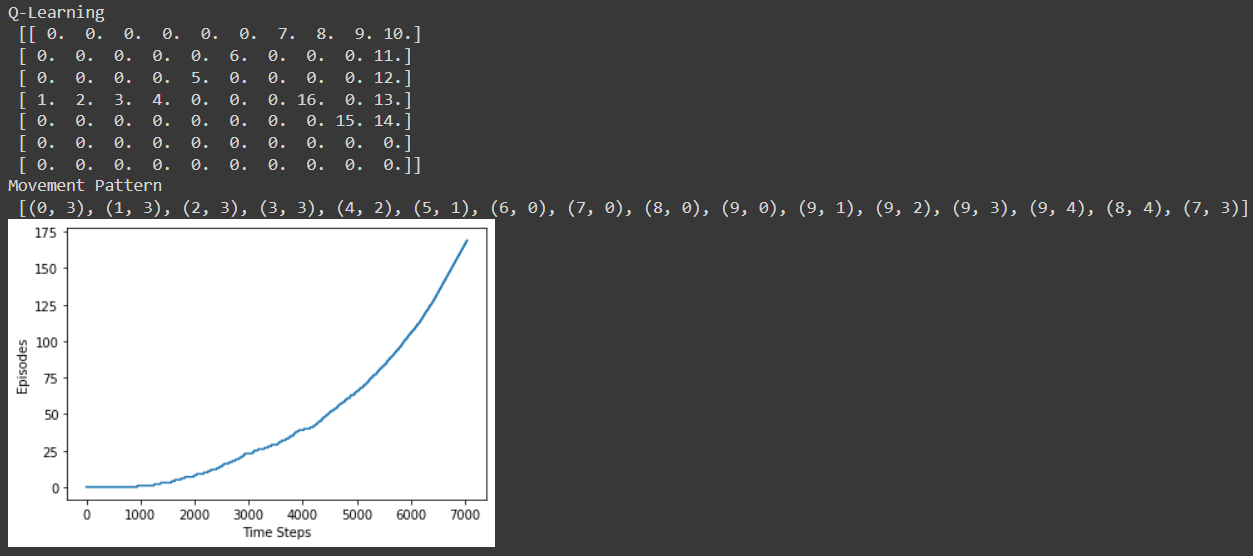

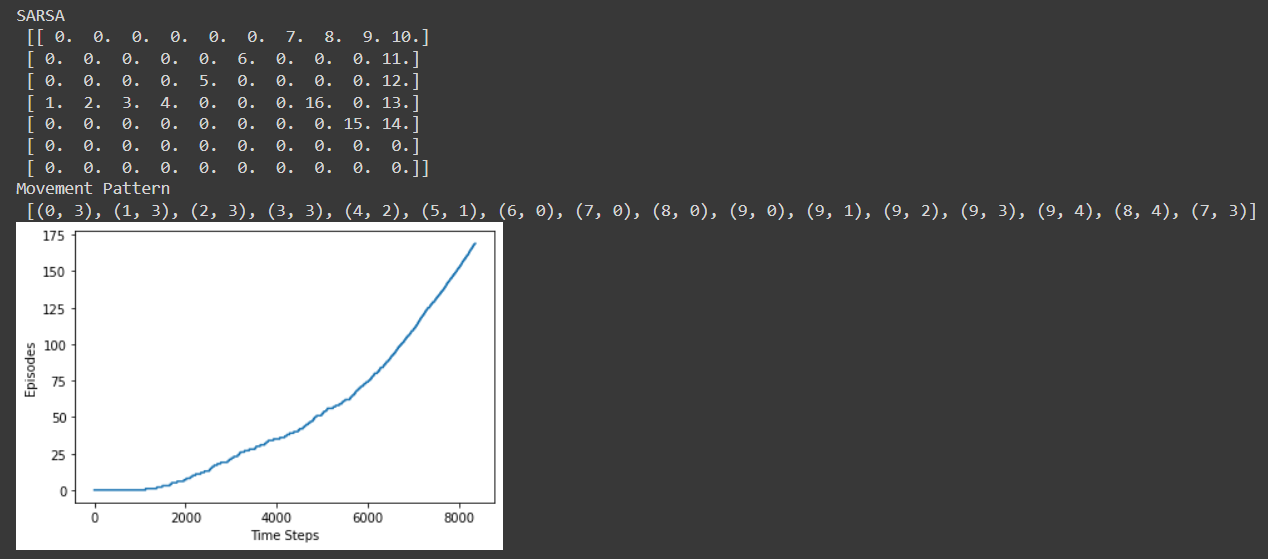
2. Comparisons of solutions for the first case is worth 20 points.

When looking between the provided output I have gotten from running my agents, we can see that with both having an alpha of 0.5 and an epsilon of 0.1 were able to find the optimal policy. There is a difference between these two agents, that being that the SARSA agent took 8000 time steps upon reaching its 170th episode while Q-Learning took 7000 time steps upon reaching its 170th episode.

3. Implementation of all algorithms for the second case (stochastic wind) is worth 30 points. This
includes the quality of your code and its correctness.
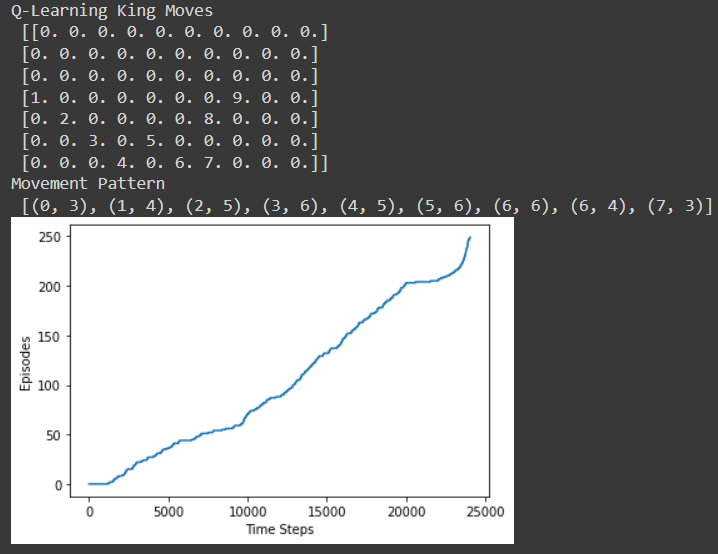

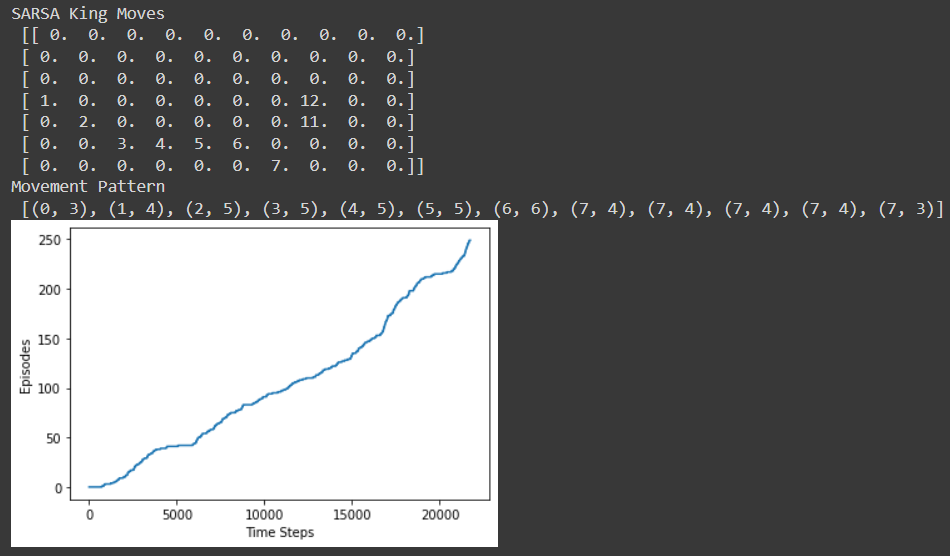

4. Comparisons of solutions for the stochastic case is worth 20 points.

When looking between the two agents for king movements with stochastic wind, both using an alpha of 0.9 and an epsilon of 0.001, we can see that it does take the Q-Learning agent about 25000 steps by the 250th episode, but the SARSA agent takes about 20000 steps by the 250th episode. While this is the case, we can see by the end of the episodes that it does take less steps for the Q-Learning agent than the SARSA agent when they are run through the evaluator.

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
class Gridworld(object):
  def __init__(self, x_len=10, y_len=7, start_col=0, start_row=3, king_moves=False):
    self.cols = x_len
    self.rows = y_len
    self.current_col = start_col
    self.current_row = start_row
    self.start_col = start_col
    self.start_row = start_row
    #terminal state is fixed
    self.term_col = 7
    self.term_row = 3
    self.wind = (0, 0, 0, 1, 1, 1, 2, 2, 1, 0)
    
    if king_moves:
      #{North, South, East, West, NorthWest, NorthEast, SouthWest, SouthEast}
      self.movements = {"N": (1, 0), "S": (-1, 0), "E": (0, 1), "W": (0, -1),
                        "NW": (1, -1), "NE": (1, 1), "SW": (-1, -1), "SE": (-1, 1)}
      self.keys = ("N", "S", "E", "W", "NW", "NE", "SW", "SE")
    else:
      #{North, South, East, West}
      self.movements = {"N": (1, 0), "S": (-1, 0), "E": (0, 1), "W": (0, -1)}
      self.keys = ("N", "S", "E", "W")

    self.stochastic_winds = king_moves

In [ ]:
class Agent(object):
  def __init__(self, alpha=0.5, epsilon=0.1, gamma=1, stochastic=False):
    self.alpha = alpha
    self.epsilon = epsilon
    self.gamma = gamma
    self.gw = Gridworld(king_moves=stochastic)
    self.steps = 0
    self.step_episode_list = []

    #creating the q_table based on movement type
    self.qtable = {}
    if self.gw.stochastic_winds:
      for col in range(self.gw.cols):
        for row in range(self.gw.rows):
          pos = (col, row)
          self.qtable[pos] = {"N": 0, "S": 0, "E": 0, "W": 0,
                              "NW": 0, "NE": 0, "SW": 0, "SE": 0}
    else:
      for col in range(self.gw.cols):
        for row in range(self.gw.rows):
          pos = (col, row)
          self.qtable[pos] = {"N": 0, "S": 0, "E": 0, "W": 0}

In [ ]:
def get_action(agent, col, row, q = False):
  #epsilon greedy choosing
  if np.random.rand() < agent.epsilon and not q:
    action = np.random.choice(agent.gw.keys)
  else:
    action = max(agent.qtable[(col, row)], key=agent.qtable[(col, row)].get)

  return action

In [ ]:
def movement(agent, a):
  stochastic_wind_adjustment = 0

  if agent.gw.stochastic_winds and agent.gw.wind[agent.gw.current_col] != 0:
    stochastic_wind_adjustment = random.randint(-1,1)

  row_prime = agent.gw.current_row + agent.gw.movements[a][0] - agent.gw.wind[agent.gw.current_col] + stochastic_wind_adjustment
  col_prime = agent.gw.current_col + agent.gw.movements[a][1]

  if row_prime >= agent.gw.rows:
      row_prime = agent.gw.rows - 1
  elif row_prime < 0:
      row_prime = 0

  if col_prime >= agent.gw.cols:
      col_prime = agent.gw.cols - 1
  elif col_prime < 0:
      col_prime = 0

  return col_prime, row_prime

In [ ]:
def q_learning(agent, episode):
  prev_pos = [(agent.gw.start_col, agent.gw.start_row)]
  action = get_action(agent, agent.gw.current_col, agent.gw.current_row, q=True)
  reward = -1

  while True:
    col_prime, row_prime = movement(agent, action)
    prev_pos.append((col_prime, row_prime))

    action_prime = get_action(agent, col_prime, row_prime, q=True)

    agent.qtable[(agent.gw.current_col, agent.gw.current_row)][action] += (
        agent.alpha * (reward + agent.gamma *
                       agent.qtable[(col_prime, row_prime)][action_prime]
                       - agent.qtable[(agent.gw.current_col, agent.gw.current_row)][action]))
    
    agent.gw.current_col = col_prime
    agent.gw.current_row = row_prime
    action = action_prime
    agent.steps += 1
    agent.step_episode_list.append(episode)

    if agent.gw.current_col == agent.gw.term_col and agent.gw.current_row == agent.gw.term_row:
      break

  return prev_pos

In [ ]:
def sarsa(agent, episode):
  prev_pos = [(agent.gw.start_col, agent.gw.start_row)]
  action = get_action(agent, agent.gw.current_col, agent.gw.current_row)
  reward = -1

  while True:
    col_prime, row_prime = movement(agent, action)
    prev_pos.append((col_prime, row_prime))

    action_prime = get_action(agent, col_prime, row_prime)

    agent.qtable[(agent.gw.current_col, agent.gw.current_row)][action] += (
        agent.alpha * (reward + agent.gamma *
                       agent.qtable[(col_prime, row_prime)][action_prime]
                       - agent.qtable[(agent.gw.current_col, agent.gw.current_row)][action]))

    agent.gw.current_col = col_prime
    agent.gw.current_row = row_prime
    action = action_prime
    agent.steps += 1
    agent.step_episode_list.append(episode)

    if agent.gw.current_col == agent.gw.term_col and agent.gw.current_row == agent.gw.term_row:
      break
  
  return prev_pos

In [ ]:
def evaluate(agent):
  prev_pos = [(agent.gw.start_col, agent.gw.start_row)]
  action = max(agent.qtable[(agent.gw.current_col, agent.gw.current_row)], key=agent.qtable[(agent.gw.current_col, agent.gw.current_row)].get)
  reward = -1

  while True:
    col_prime, row_prime = movement(agent, action)
    prev_pos.append((col_prime, row_prime))

    action_prime = max(agent.qtable[(col_prime, row_prime)], key=agent.qtable[(col_prime, row_prime)].get)

    #agent.qtable[(agent.gw.current_col, agent.gw.current_row)][action] += (
    #    agent.alpha * (reward + agent.gamma *
    #                   agent.qtable[(col_prime, row_prime)][action_prime]
    #                   - agent.qtable[(agent.gw.current_col, agent.gw.current_row)][action]))

    agent.gw.current_col = col_prime
    agent.gw.current_row = row_prime
    action = action_prime

    if agent.gw.current_col == agent.gw.term_col and agent.gw.current_row == agent.gw.term_row:
      break
  
  return prev_pos

In [ ]:
def plotting(agent):
  plt.plot(agent.step_episode_list)
  plt.xlabel("Time Steps")
  plt.ylabel("Episodes")

SARSA
 [[ 0.  0.  0.  0.  0.  0.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  0.  6.  0.  0.  0. 11.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 12.]
 [ 1.  2.  3.  4.  0.  0.  0. 16.  0. 13.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 15. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]] 
Movement Pattern
 [(0, 3), (1, 3), (2, 3), (3, 3), (4, 2), (5, 1), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (8, 4), (7, 3)]


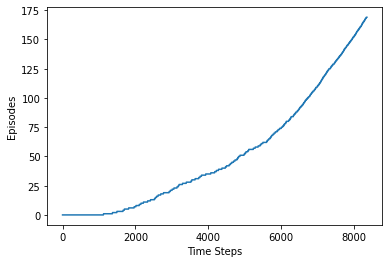

In [ ]:
max_episodes = 170

sarsa_agent = Agent()

for episode in range(max_episodes):
  sarsa_prev_pos = sarsa(sarsa_agent, episode)
  sarsa_agent.gw.current_col = sarsa_agent.gw.start_col
  sarsa_agent.gw.current_row = sarsa_agent.gw.start_row

sarsa_grid = np.zeros((sarsa_agent.gw.rows, sarsa_agent.gw.cols))

sarsa_prev_pos = evaluate(sarsa_agent)

for i in range(len(sarsa_prev_pos)):
  sarsa_grid[sarsa_prev_pos[i][1]][sarsa_prev_pos[i][0]] = i + 1

print("SARSA\n", sarsa_grid, "\nMovement Pattern\n", sarsa_prev_pos)
plotting(sarsa_agent)

Q-Learning
 [[ 0.  0.  0.  0.  0.  0.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  0.  6.  0.  0.  0. 11.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 12.]
 [ 1.  2.  3.  4.  0.  0.  0. 16.  0. 13.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 15. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]] 
Movement Pattern
 [(0, 3), (1, 3), (2, 3), (3, 3), (4, 2), (5, 1), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (8, 4), (7, 3)]


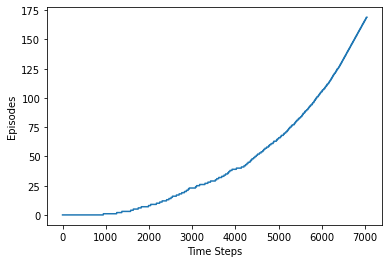

In [ ]:
max_episodes = 170

q_learning_agent = Agent()

for episode in range(max_episodes):
  q_learning_prev_pos = q_learning(q_learning_agent, episode)
  q_learning_agent.gw.current_col = q_learning_agent.gw.start_col
  q_learning_agent.gw.current_row = q_learning_agent.gw.start_row

q_learning_grid = np.zeros((q_learning_agent.gw.rows, q_learning_agent.gw.cols))

q_learning_prev_pos = evaluate(q_learning_agent)

for i in range(len(q_learning_prev_pos)):
  q_learning_grid[q_learning_prev_pos[i][1]][q_learning_prev_pos[i][0]] = i + 1

print("Q-Learning\n", q_learning_grid, "\nMovement Pattern\n", q_learning_prev_pos)
plotting(q_learning_agent)

SARSA King Moves
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0. 12.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0. 11.  0.  0.]
 [ 0.  0.  3.  4.  5.  6.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  7.  0.  0.  0.]] 
Movement Pattern
 [(0, 3), (1, 4), (2, 5), (3, 5), (4, 5), (5, 5), (6, 6), (7, 4), (7, 4), (7, 4), (7, 4), (7, 3)]


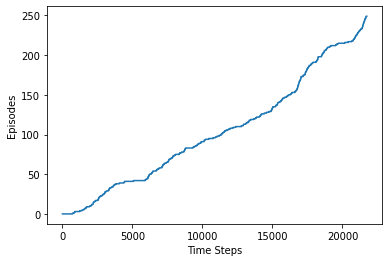

In [ ]:
max_episodes = 250

sarsa_king_agent = Agent(alpha = 0.9, epsilon = 0.001, stochastic=True)

for episode in range(max_episodes):
  sarsa_king_prev_pos = sarsa(sarsa_king_agent, episode)
  sarsa_king_agent.gw.current_col = sarsa_king_agent.gw.start_col
  sarsa_king_agent.gw.current_row = sarsa_king_agent.gw.start_row

sarsa_king_grid = np.zeros((sarsa_king_agent.gw.rows, sarsa_king_agent.gw.cols))

sarsa_king_prev_pos = evaluate(sarsa_king_agent)

for i in range(len(sarsa_king_prev_pos)):
  sarsa_king_grid[sarsa_king_prev_pos[i][1]][sarsa_king_prev_pos[i][0]] = i + 1

print("SARSA King Moves\n", sarsa_king_grid, "\nMovement Pattern\n", sarsa_king_prev_pos)
plotting(sarsa_king_agent)

Q-Learning King Moves
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 9. 0. 0.]
 [0. 2. 0. 0. 0. 0. 8. 0. 0. 0.]
 [0. 0. 3. 0. 5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 0. 6. 7. 0. 0. 0.]] 
Movement Pattern
 [(0, 3), (1, 4), (2, 5), (3, 6), (4, 5), (5, 6), (6, 6), (6, 4), (7, 3)]


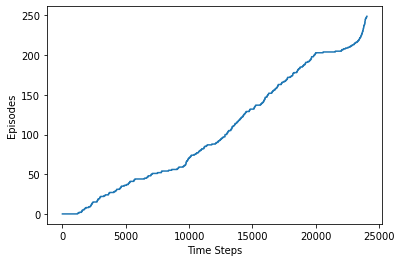

In [ ]:
max_episodes = 250

q_learning_king_agent = Agent(alpha = 0.9, epsilon = 0.001, stochastic=True)

for episode in range(max_episodes):
  q_learning_king_prev_pos = q_learning(q_learning_king_agent, episode)
  q_learning_king_agent.gw.current_col = q_learning_king_agent.gw.start_col
  q_learning_king_agent.gw.current_row = q_learning_king_agent.gw.start_row

q_learning_king_grid = np.zeros((q_learning_king_agent.gw.rows, q_learning_king_agent.gw.cols))

q_learning_king_prev_pos = evaluate(q_learning_king_agent)

for i in range(len(q_learning_king_prev_pos)):
  q_learning_king_grid[q_learning_king_prev_pos[i][1]][q_learning_king_prev_pos[i][0]] = i + 1

print("Q-Learning King Moves\n", q_learning_king_grid, "\nMovement Pattern\n", q_learning_king_prev_pos)
plotting(q_learning_king_agent)